In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from collections import defaultdict
import panns_inference
from panns_inference import AudioTagging, SoundEventDetection, labels

import sys
sys.path.append('../ASC_AED_JoinTask/Datasets/')
sys.path.append('../ASC_AED_JoinTask/models/')
import ASC_datasets
import audio_utils as au

TUT_AUD_DIR = ASC_datasets.TUT_AUD_DIR
SAMPLE_RATE = 32000

In [139]:
csv = 'tut_preds/Cnn9_64mel_tut_ablatedScenePreds.csv'
df = pd.read_csv(csv)
scenes = df.scene_preds.unique()

In [140]:
at = AudioTagging(checkpoint_path='../ASC_AED_JoinTask/models/Cnn14_mAP=0.431.pth', device='cuda')

def get_event_list(clipwise_output):
    # With the slicing, we are reversing the sorted index to get the descending order of event probs.
    sorted_indexes = np.argsort(clipwise_output)[::-1]
    event_list = []

    # Creating a list of events with more than 0.05 prob
    for i in range(0, len(sorted_indexes)):
        event_prob = clipwise_output[sorted_indexes[i]]
        if event_prob > 0.1:
            event_list.append(np.array(labels)[sorted_indexes[i]])
    
    return event_list


def get_panns_events_list(audio):
    
    audio = audio[None, :]
    clipwise_op, embedding = at.inference(audio)

    event_list = get_event_list(clipwise_op[0])
    return event_list

Checkpoint path: ../ASC_AED_JoinTask/models/Cnn14_mAP=0.431.pth
GPU number: 4


In [23]:
# Loop for predicting audio tags for the original audio
audio_tags_org = []

for i, row in df.iterrows():
    fname = os.path.join(TUT_AUD_DIR, row['files'])
    audio = au.load_audio_from_file(fname, sample_rate=SAMPLE_RATE)
    audio_tags_org.append(get_panns_events_list(audio))

In [27]:
df['audio_tags_org'] = audio_tags_org

In [32]:
audioset_ontology_df = pd.read_json('audioset_ontology.json')

def get_event_ids(event_id):
    idx = audioset_ontology_df[audioset_ontology_df['child_ids'].apply(lambda x: event_id in x)]
    if len(idx) > 0:
        return idx['id'].iloc[0]
    else:
        return 'None'
    
def get_immediate_parent_class_label(event_label):
    event_row = audioset_ontology_df.loc[audioset_ontology_df['name']==event_label]
    event_id = event_row['id'].to_string(index=False)
    parent_event_id = get_event_ids(event_id)
    parent_class_label = audioset_ontology_df[audioset_ontology_df['id']==parent_event_id]['name'].to_string(index=False)
    if parent_event_id == 'None':
        return 'None'
    else:
        return parent_class_label

def get_parent_class_label(event_label):
    event_row = audioset_ontology_df.loc[audioset_ontology_df['name']==event_label]
    event_id = event_row['id'].to_string(index=False)
    parent_event_id = get_event_ids(event_id)
    while get_event_ids(parent_event_id) != 'None':
        parent_event_id = get_event_ids(parent_event_id)
    parent_class_label = audioset_ontology_df[audioset_ontology_df['id']==parent_event_id]['name'].to_string(index=False)
    if parent_event_id == 'None':
        return 'None'
    else:
        return parent_class_label


In [93]:
import ast

csv = 'tut_preds/Cnn9_64mel_tut_ablatedScenePreds_withOrgTags.csv'
df = pd.read_csv(csv)
scenes = df['labels'].unique()
df['audio_tags_org'] = df['audio_tags_org'].apply(lambda x: ast.literal_eval(x))

In [94]:
# Counting all the tags in the original audio
all_tags = set()

rearranged_filtered_tags = ['Outside, urban or manmade', 'Inside, public space', 'Wind', 'Recording', 'Ocean', 'Animal',
 'Human sounds', 'Human locomotion', 'Clip-clop', 'Rail transport', 'Vehicle', 'Music',
 'Aircraft', 'Rumble', 'Clickety-clack']

for i, row in df.iterrows():
    tags = row['audio_tags_org']
    for tag in tags:
        all_tags.add(tag)

In [95]:
# PANNs unique audio tags and counts for each scene
scene_tag_counts = defaultdict(dict)
all_tags = list(all_tags)

for scene in scenes:
    for tag in all_tags:
        scene_tag_counts[scene][tag] = 0


# Counting the tags for each scene
for i, row in df.iterrows():
    tags = row['audio_tags_org']
    for tag in tags:
        scene_tag_counts[row['labels']][tag] += 1


# Initiliasing the rearranged filtered tags
scene_filtered_tags_counts = defaultdict(dict)
for scene in scenes:
    for tag in rearranged_filtered_tags:
        scene_filtered_tags_counts[scene][tag] = 0

In [96]:
pd.DataFrame(scene_tag_counts)['airport'].sort_values(ascending=False)

Speech                       252
Vehicle                      244
Train                         74
Outside, urban or manmade     67
Music                         63
                            ... 
Inside, small room             0
Civil defense siren            0
Duck                           0
Slam                           0
Crack                          0
Name: airport, Length: 162, dtype: int64

In [97]:
# Creating a dataframe
scene_tag_counts_df = pd.DataFrame.from_dict(scene_tag_counts)

# Actually counting the filtered tags based on a threshold
for scene in scenes:
    # Need commenting after we have decided upon an approach
    total_files = df['labels'].value_counts()[scene]
    #total_tags_per_scene = scene_tag_counts_df[scene].sum()

    for index in scene_tag_counts_df.index:
        #scene_tag_counts_df[scene][index] = (scene_tag_counts_df[scene][index])/total
        tag = index
        if (scene_tag_counts_df[scene][index])/total_files > 0.1:
            if index in rearranged_filtered_tags:
                scene_filtered_tags_counts[scene][index] += (scene_tag_counts_df[scene][index])
            else:
                while tag not in rearranged_filtered_tags:
                    tag = get_immediate_parent_class_label(tag)
                scene_filtered_tags_counts[scene][tag] += (scene_tag_counts_df[scene][index])


In [98]:
pd.DataFrame(scene_filtered_tags_counts)['airport'].sort_values(ascending=False)

Vehicle                      314
Human sounds                 302
Rail transport               220
Outside, urban or manmade     67
Music                         63
Human locomotion              30
Inside, public space           0
Wind                           0
Recording                      0
Ocean                          0
Animal                         0
Clip-clop                      0
Aircraft                       0
Rumble                         0
Clickety-clack                 0
Name: airport, dtype: int64

In [99]:
# Normalizing the filtered tags
scene_filtered_tags_counts_df = pd.DataFrame.from_dict(scene_filtered_tags_counts)

for scene in scenes:
    total = scene_filtered_tags_counts_df[scene].sum()
    #total = df['labels'].value_counts()[scene]
    for index in scene_filtered_tags_counts_df.index:
        scene_filtered_tags_counts_df[scene][index] = (scene_filtered_tags_counts_df[scene][index])/total

/tmp/ipykernel_2063803/2578130740.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.06726907630522089' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  scene_filtered_tags_counts_df[scene][index] = (scene_filtered_tags_counts_df[scene][index])/total
/tmp/ipykernel_2063803/2578130740.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scene_filtered_tags_counts_df[scene][index] = (scene_filtered_tags_counts_df[scene][index])/total
/tmp/ipykernel_2063803/2578130740.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.057624113475177305' has dtype incompatible with int64, please explicitly cast to a compatible dtype fir

<Axes: title={'center': 'Normalised values for predicted audio tags in scenes using original audio'}>

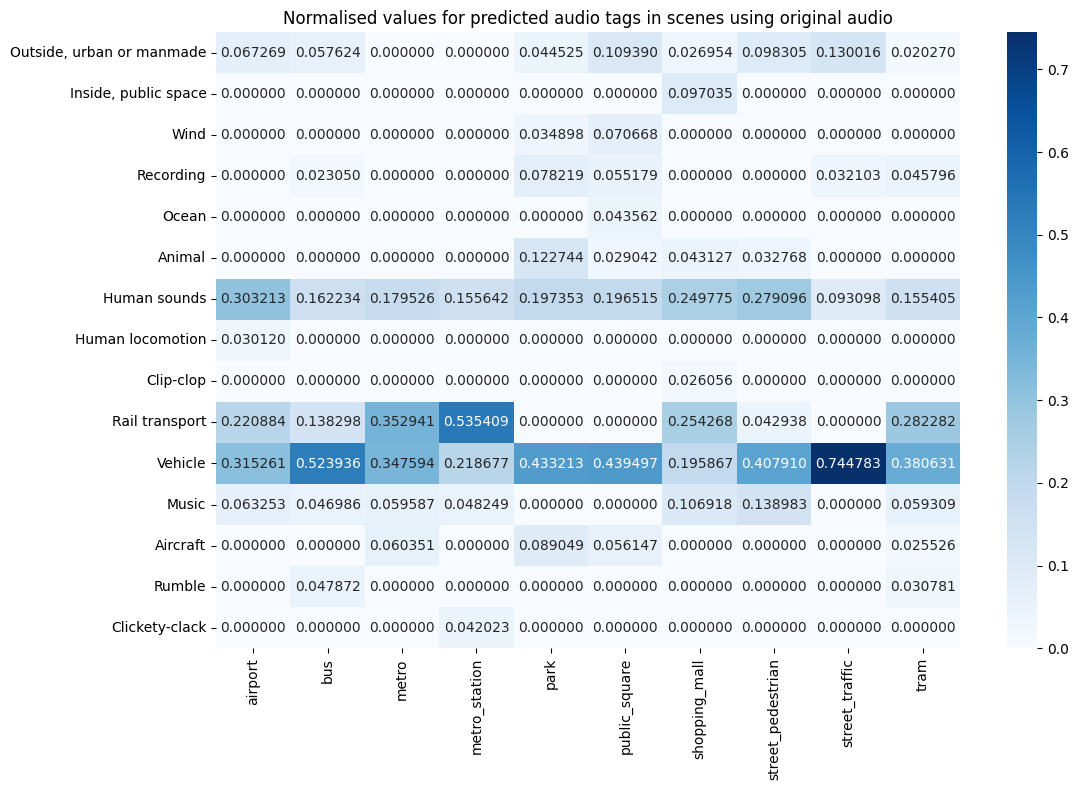

In [100]:
plt.figure(figsize=(12,8))
plt.title('Normalised values for predicted audio tags in scenes using original audio')
sns.heatmap(scene_filtered_tags_counts_df, fmt='f', annot=True, cmap='Blues')

In [103]:
# Now we want to understand the model behavior
# We will use the audio tags from the original dataset to understand the patterns that the model might have observed
correct_scene_tags_count = defaultdict(dict)
correct_scene_filtered_tags_count = defaultdict(dict)
# Initialiing the dict
for scene in scenes:
    for tag in all_tags:
        correct_scene_tags_count[scene][tag] = 0
    for tag in rearranged_filtered_tags:
        correct_scene_filtered_tags_count[scene][tag] = 0
# Counting
for i, row in df.iterrows():
    tags = row['audio_tags_org']
    # We can change the following condition in order to see the behavior of the model for a specific type of predictions (correctly predicted or mispredicted)
    # if this condition is commented, that means we are observing the behavior of all the PREDICTIONS
    #if row['labels'] != row['scene_preds']:
    for tag in tags:
        correct_scene_tags_count[row['scene_preds']][tag] += 1

# Counting the filtered tags
for scene in scenes:
    #total = len(df[df['labels'] == scene][df['scene_preds']!=scene])

    # As was the case earlier, we are only considering audio tags having a threshold of 14%
    #total = len(df[df['scene_preds']==scene])
    total = df['scene_preds'].value_counts()[scene]
    for tag in all_tags:
        index = tag
        print(index)
        if (correct_scene_tags_count[scene][tag])/total > 0.14:
            # We then merge the tag count to the filtered tags
            if tag in rearranged_filtered_tags:
                correct_scene_filtered_tags_count[scene][tag] += (correct_scene_tags_count[scene][tag])
            else:
                while index not in rearranged_filtered_tags:
                    index = get_immediate_parent_class_label(index)
                correct_scene_filtered_tags_count[scene][index] += (correct_scene_tags_count[scene][tag])


Musical instrument
Outside, urban or manmade
Train whistle
Eruption
Jet engine
Sailboat, sailing ship
Foghorn
Rumble
Change ringing (campanology)
Ping
Bird
Car
Air conditioning
Waterfall
Scary music
Siren
Train wheels squealing
Fire alarm
Coo
Caw
Power windows, electric windows
Car passing by
Bow-wow
Keys jangling
Accelerating, revving, vroom
Idling
Narration, monologue
Pink noise
Slosh
Children playing
Creak
Doorbell
Inside, large room or hall
Chop
Spray
Fusillade
Mechanisms
Throat clearing
Electric guitar
Wind noise (microphone)
Mouse
Female speech, woman speaking
Sheep
Run
Clickety-clack
Zipper (clothing)
Male speech, man speaking
Speech
Slam
Duck
Field recording
Civil defense siren
Inside, small room
Door
Domestic animals, pets
Car alarm
Ambulance (siren)
Ship
Chopping (food)
Environmental noise
Traffic noise, roadway noise
Sliding door
Engine
Subway, metro, underground
Fire engine, fire truck (siren)
Orchestra
Classical music
Clip-clop
Neigh, whinny
Goat
Walk, footsteps
Sizzle
Rai

In [104]:
# Normalizing the filtered tags
correct_scene_filtered_tags_count_df = pd.DataFrame.from_dict(correct_scene_filtered_tags_count)

for scene in scenes:
    # Normalizing wrt the total number of audio tags predicted for that scene
    total = correct_scene_filtered_tags_count_df[scene].sum()
    #total = df['labels'].value_counts()[scene]
    
    for index in scene_filtered_tags_counts_df.index:
        correct_scene_filtered_tags_count_df[scene][index] = (correct_scene_filtered_tags_count_df[scene][index])/total

/tmp/ipykernel_2063803/2419815757.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.1375' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  correct_scene_filtered_tags_count_df[scene][index] = (correct_scene_filtered_tags_count_df[scene][index])/total
/tmp/ipykernel_2063803/2419815757.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  correct_scene_filtered_tags_count_df[scene][index] = (correct_scene_filtered_tags_count_df[scene][index])/total
/tmp/ipykernel_2063803/2419815757.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.06318082788671024' has dtype incompatible with int64, please explicitly cast to a com

<Axes: title={'center': 'Normalised values for filtered audio tags in predicted scenes'}>

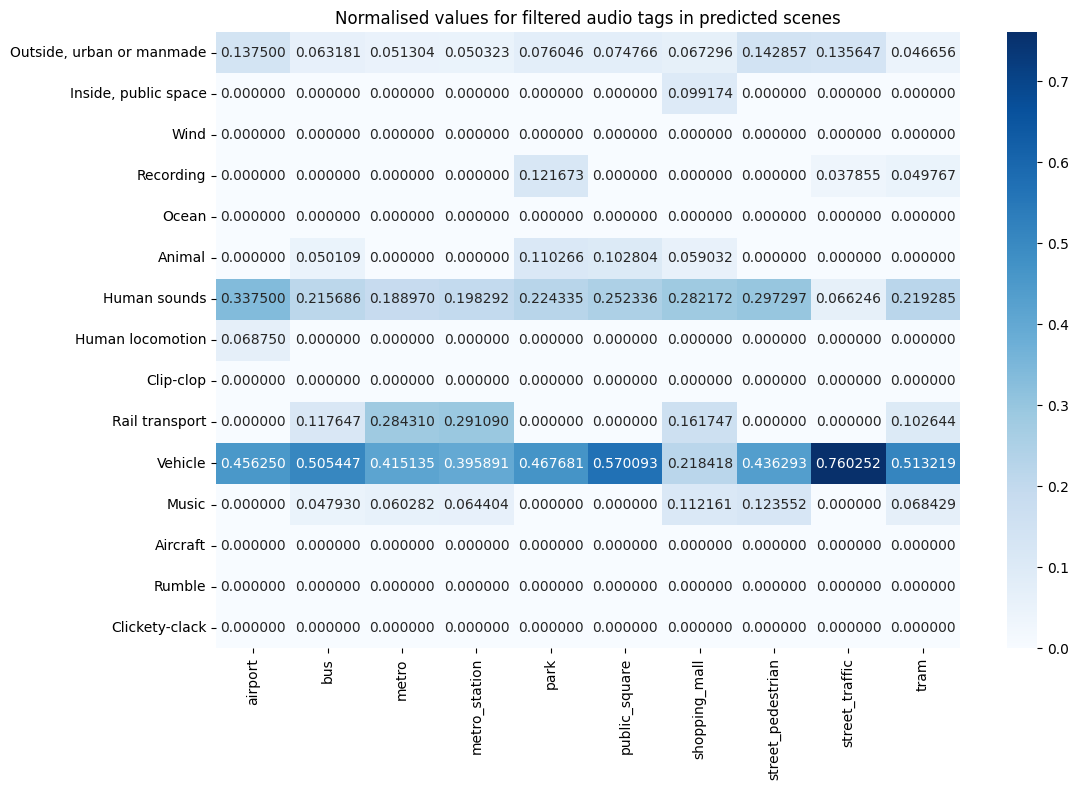

In [105]:
plt.figure(figsize=(12,8))
plt.title('Normalised values for filtered audio tags in predicted scenes')
sns.heatmap(correct_scene_filtered_tags_count_df, fmt='f', annot=True, cmap='Blues')

<Axes: >

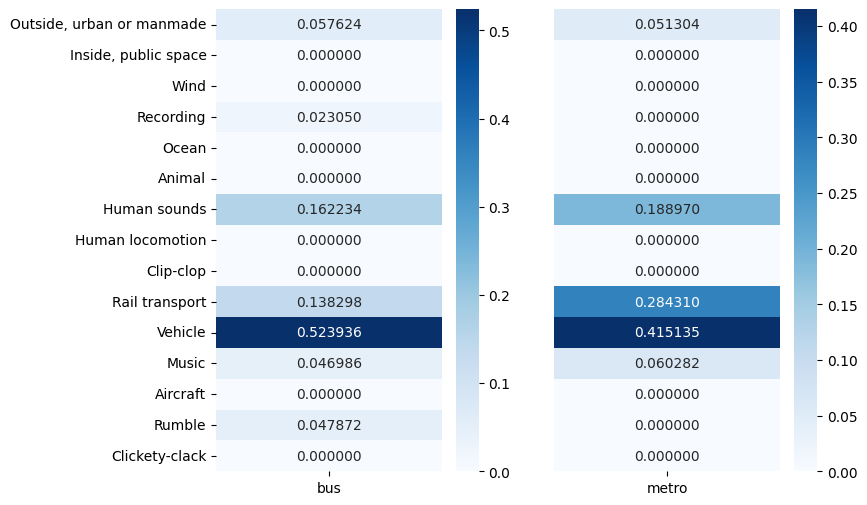

In [115]:
plt.figure(figsize=(8,6))
plt.subplot(1, 2, 1)
sns.heatmap(scene_filtered_tags_counts_df[['bus']], fmt='f', annot=True, cmap='Blues')
plt.subplot(1, 2, 2)
sns.heatmap(correct_scene_filtered_tags_count_df[['metro']], fmt='f', annot=True, cmap='Blues', yticklabels=False)

<Axes: >

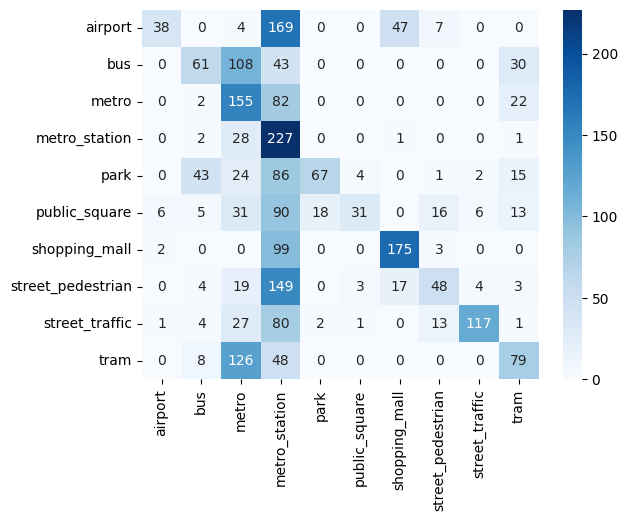

In [93]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(df['labels'], df['scene_preds'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=scenes, yticklabels=scenes)